In [1]:
%config IPCompleter.greedy=True

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

In [3]:
ratings_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/ratings.csv')
movies_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/movies.csv')
tags_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/tags.csv')
links_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/links.csv')

### Dataset

In [4]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [5]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


### Data preperation

The ids are not consecutive. For examples the id of a movies is shown multiple times. For this reason the procedure below is implemented. The reversed map is still saved to be used if needed.

In [6]:
from collections import defaultdict
from itertools import count

uid_map = defaultdict(count().__next__)
iid_map = defaultdict(count().__next__)
uids = np.array([uid_map[uid] for uid in ratings_df["userId"].values ], dtype=np.int32)
iids = np.array([iid_map[iid] for iid in ratings_df["movieId"].values ], dtype=np.int32)

uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}

ratings = ratings_df["rating"].values.astype(np.float32)
timestamps = ratings_df["timestamp"].values.astype(np.int32)

print("userId %d got uid %d" % (556, uid_map[556]))
print("movieId %d got iid %d" % (54001, iid_map[54001]))

userId 556 got uid 555
movieId 54001 got iid 2518


Create the dataset variable representing the dataset prepared for use to create a recommendation systems using the Spotlight platform.

### Implicit Factorization model

In [7]:
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  

explicit_interaction = Interactions(user_ids=uids,
                                  item_ids=iids,
                                  ratings=ratings,
                                  timestamps=timestamps)

#pecify the ids of the users and items for all the pairs of user-item interactions
implicit_interaction = Interactions(user_ids=uids,
                                   item_ids=iids)


#lets initialise the seed, so that its repeatable and reproducible 
explicit_train, explicit_test = random_train_test_split(explicit_interaction, random_state=np.random.seed(42))
implicit_train, implicit_test = random_train_test_split(implicit_interaction, random_state=np.random.seed(42))

In [8]:
print(implicit_train)
print(implicit_test)

<Interactions dataset (610 users x 9724 items x 80668 interactions)>
<Interactions dataset (610 users x 9724 items x 20168 interactions)>


In [9]:
implicit_model  = ImplicitFactorizationModel(n_iter = 5)

current = time.time()

implicit_model.fit(implicit_train,verbose = True)

end = time.time()
diff = end - current
print('Training took %d second'%(diff))

Epoch 0: loss 0.7019506872077531
Epoch 1: loss 0.43651273554261727
Epoch 2: loss 0.40412026266508466
Epoch 3: loss 0.36894451081752777
Epoch 4: loss 0.33545720539515533
Training took 36 second


The predictions should be for all items. Below is the prediction for the first item

In [10]:
print(implicit_model.predict(1))

[15.852799   4.62809   12.6582775 ... -8.141538  -8.950054  -8.377075 ]


In [11]:
'''from spotlight.evaluation import mrr_score
print(mrr_score(explicit_model, test, train=train, k=100).mean())'''

'from spotlight.evaluation import mrr_score\nprint(mrr_score(explicit_model, test, train=train, k=100).mean())'

Distribution of scores

(array([1.000e+00, 9.000e+00, 3.000e+01, 7.800e+01, 2.460e+02, 5.910e+02,
        1.038e+03, 1.363e+03, 1.256e+03, 8.530e+02, 5.230e+02, 3.520e+02,
        3.630e+02, 2.760e+02, 2.210e+02, 1.900e+02, 1.760e+02, 1.580e+02,
        1.580e+02, 1.220e+02, 1.140e+02, 1.090e+02, 1.000e+02, 1.190e+02,
        9.300e+01, 1.120e+02, 8.900e+01, 9.800e+01, 1.000e+02, 9.100e+01,
        9.800e+01, 1.070e+02, 1.180e+02, 9.400e+01, 1.010e+02, 7.500e+01,
        3.900e+01, 3.400e+01, 1.800e+01, 1.100e+01]),
 array([-15.21318   , -14.433863  , -13.654546  , -12.87523   ,
        -12.095913  , -11.316596  , -10.537279  ,  -9.757962  ,
         -8.978645  ,  -8.199329  ,  -7.4200125 ,  -6.6406956 ,
         -5.8613787 ,  -5.0820622 ,  -4.3027453 ,  -3.5234284 ,
         -2.7441118 ,  -1.9647951 ,  -1.1854783 ,  -0.4061616 ,
          0.37315512,   1.1524719 ,   1.9317886 ,   2.7111053 ,
          3.490422  ,   4.2697387 ,   5.0490556 ,   5.8283725 ,
          6.607689  ,   7.387006  ,   8.166323  ,   8.

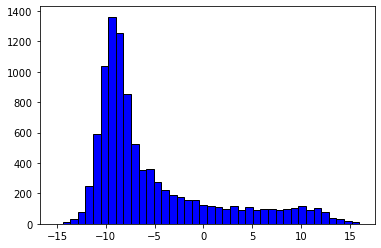

In [12]:
plt.hist(implicit_model.predict(0), color = 'blue', edgecolor = 'black',
         bins = 40)

### Top-K predictions

In [13]:
import scipy.stats as st

def moviesForUser(user, k=100):
  a= list()
  ranks = st.rankdata(-implicit_model.predict(user))  
  for iid in np.argwhere(ranks <= k):
    #print(iid_rev_map[iid.item(0)])
    a.append(iid_rev_map[iid.item(0)])
  return a

l_rec = moviesForUser(0)

In [14]:
movies_df.loc[movies_df['movieId'].isin([1090, 733, 780, 1198,2000,2617, 1704, 589,2194, 1356])]

,movieId,title,genres
507,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi
592,733,"Rock, The (1996)",Action|Adventure|Thriller
615,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller
829,1090,Platoon (1986),Drama|War
900,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
1044,1356,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi|Thriller
1284,1704,Good Will Hunting (1997),Drama|Romance
1475,2000,Lethal Weapon (1987),Action|Comedy|Crime|Drama
1645,2194,"Untouchables, The (1987)",Action|Crime|Drama
1972,2617,"Mummy, The (1999)",Action|Adventure|Comedy|Fantasy|Horror|Thriller


In [15]:
movies_df.loc[movies_df['movieId'].isin(l_rec)]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
6,7,Sabrina (1995),Comedy|Romance
9,10,GoldenEye (1995),Action|Adventure|Thriller
10,11,"American President, The (1995)",Comedy|Drama|Romance
16,17,Sense and Sensibility (1995),Drama|Romance
...,...,...,...
1858,2470,Crocodile Dundee (1986),Adventure|Comedy
1939,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
1987,2641,Superman II (1980),Action|Sci-Fi
2145,2858,American Beauty (1999),Drama|Romance


In [16]:
implicit_model._net.item_embeddings.weight[0]

tensor([ 0.6330,  0.7841,  0.4224, -0.7390, -0.6971,  0.6050,  0.7460, -0.3751,
         0.8625,  0.8402,  1.1899, -0.8114, -1.3875, -0.8083, -0.9609,  1.3058,
         0.6883,  0.4837, -0.7890, -0.9808,  1.7700,  0.4161, -1.3977, -0.9438,
         0.2157,  0.5045,  0.4047,  1.4703,  0.3290, -0.7396,  0.6354, -0.3288],
       grad_fn=<SelectBackward>)

In [17]:
len(implicit_model._net.item_embeddings.weight[0])

32

In [18]:
len(implicit_model.predict(1))

9724

### Actual movies watched

In [26]:
a = ratings_df[ratings_df["userId"]==uid_rev_map.get(0)].groupby("movieId")["movieId"].count().sort_values(ascending=False).head(5)

In [32]:
a = a.index.tolist()

In [35]:
movies_df.loc[movies_df['movieId'].isin(a)]

,movieId,title,genres
909,1208,Apocalypse Now (1979),Action|Drama|War
955,1256,Duck Soup (1933),Comedy|Musical|War
957,1258,"Shining, The (1980)",Horror
964,1265,Groundhog Day (1993),Comedy|Fantasy|Romance
3673,5060,M*A*S*H (a.k.a. MASH) (1970),Comedy|Drama|War
